In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = '/content/drive/MyDrive/Data_Path'

In [3]:
from collections import Counter
import chardet
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import re

## Data Preprocessing Step: Utility Functions

In [4]:
# Directories for storing training data
training_data_dest = os.path.join(data_path, "saved_data/")
ast_folder_path = os.path.join(data_path, "AST/")
source_code_folder = os.path.join(data_path, "source_codes/")
html_output_folder = os.path.join(data_path, "output_html/")

# Initializing variables for token vector analysis
avg_token_vector_length = 0
file_names = []
all_token_vectors = []

In [5]:
def cleaned_string(input_string):
    """
    Preprocesses the input string by:
    1. Removing leading and trailing whitespace
    2. Converting the string to lowercase

    Args:
    - input_string (str): The input string to be preprocessed

    Returns:
    - str: The preprocessed string
    """
    # Removing leading and trailing whitespace, and converting to lowercase
    stripped_string = input_string.strip()
    # Converting the string to lowercase
    preprocessed_string = stripped_string.lower()
    return preprocessed_string

In [6]:
def load_data_and_labels():
    """
    Loads polarity data from files, splits the data into tokens, and generates labels.
    Returns split vectors and labels.
    """
    # Creating an empty list to store data examples
    examples = []
    # Initializing an empty list to hold corresponding labels
    labels = []

    for directory in ['with_datarace', 'without_datarace']:
        current_path = os.path.join(data_path, directory)
        for file in os.listdir(current_path):
            filename = os.fsdecode(file)
            ast_file = open(os.path.join(current_path, filename), 'r')
            token_vector = ast_file.read()
            token_vector = token_vector.strip()
            examples.append(token_vector)
            file_names.append(filename)

            if directory == 'with_datarace':
                labels.append([0, 1])
            else:
                labels.append([1, 0])

    # Cleaning and tokenizing each example
    tokenized_examples = []
    for sentence in examples:
        cleaned_sentence = cleaned_string(sentence)  # Cleaning the sentence
        split_sentence = cleaned_sentence.split(" ")  # Splitting the cleaned sentence by space
        tokenized_examples.append(split_sentence)  # Appending the split sentence to tokenized_examples list

    y_labels = np.array(labels)
    # Returning tokenized examples and labels as a list
    return [tokenized_examples, y_labels]

In [7]:
def pad_token_vectors(token_vectors, padding_word="PAD"):
    """
    Pads all token vectors to the same length. The length is defined by the longest token vector.
    Returns padded token vectors.
    """
    # Finding the length of the longest token vector in the input token vectors
    max_sequence_length = max(len(vector) for vector in token_vectors)
    print('Maximum vector size: ' + str(max_sequence_length))
    trainset_average_length = max_sequence_length

    padded_token_vectors = []
    # Iterating through each token vector in the input token vectors
    for vector in token_vectors:
        num_padding = max_sequence_length - len(vector)
        # Creating a new padded token vector by adding padding words to reach the max_sequence_length
        padded_vector = vector + [padding_word] * num_padding
        padded_token_vectors.append(padded_vector)

    # Returning the list of padded token vectors
    return padded_token_vectors

In [8]:
def average_length(sentences, padding_word="PAD"):
    """
    Pads all token vectors to the same length based on the calculated average length of token vectors.
    Returns padded token vectors.
    """
    global trainset_average_length

    total_length = sum(len(sentence) for sentence in sentences)
    number_of_all = len(sentences)

    average = int(total_length / number_of_all)
    trainset_average_length = average

    # Creating padded token vectors based on the calculated or overridden average length
    averaged_sentences = [
        sentence + [padding_word] * (average - len(sentence)) if len(sentence) < average
        else sentence[:average] if len(sentence) > average
        else sentence
        # Iterating through each token vector in sentences
        for sentence in sentences
    ]

    print('Average Length is: ' + str(average))
    # Returning the list of padded token vectors
    return averaged_sentences

In [9]:
def build_vocabulary_mapping(sentences):
    """
    Builds a vocabulary mapping from token to index based on the vector.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Step 1: Create a counter for word occurrences
    word_counts = Counter()
    for sentence in sentences:
        for word in sentence:
            word_counts[word] += 1

    # Creating an inverse vocabulary list
    vocabulary_inv = []
    # Looping through each sentence in the input sentences
    for word, count in word_counts.most_common():
        vocabulary_inv.append(word)
    # Creating an inverse vocabulary list sorted by word counts
    vocabulary_inv = list(sorted(vocabulary_inv))

    # Looping through words in the sorted vocabulary
    vocabulary = {}
    index = 0
    # Looping through the word counts in descending order
    for word in vocabulary_inv:
        vocabulary[word] = index
        index += 1

    # Returning the word-to-index mapping and inverse mapping
    return [vocabulary, vocabulary_inv]

In [10]:
def build_input_data(sentences, labels, vocabulary):
    """
    Maps token vectors and labels to vectors based on a vocabulary.
    """
    # Mapping token vectors to indices based on the provided vocabulary
    x = [[vocabulary[word] if word in vocabulary else 1 for word in sentence] for sentence in sentences]
    x = np.array(x)
    y = np.array(labels)
    # Returning the mapped token vectors and labels as a list
    return [x, y]

In [11]:
def save_processed_data(sentences_padded, file_names, vocabulary, vocabulary_inv, mapped_token_vectors, labels):
    """
    Saves various data structures as pickle files in the specified directory.

    Args:
    - sentences_padded (list): List of padded token vectors to be saved.
    - file_names (list): List of file names to be saved.
    - vocabulary (dict): Dictionary mapping words to indices to be saved.
    - vocabulary_inv (list): List of words for inverse mapping to be saved.
    - mapped_token_vectors (list): List of token vectors mapped to indices to be saved.
    - labels (list): List of labels to be saved.
    - training_data_dest (str): Directory path to save the data files.
    """
    # Defining file paths using the save_dest directory
    sentences_padded_path = os.path.join(training_data_dest, "sentences_padded.pkl")
    file_names_path = os.path.join(training_data_dest, "file_names.pkl")
    vocabulary_path = os.path.join(training_data_dest, "vocabulary.pkl")
    vocabulary_inv_path = os.path.join(training_data_dest, "vocabulary_inv.pkl")
    mapped_token_vectors_path = os.path.join(training_data_dest, "mapped_token_vectors.pkl")
    labels_path = os.path.join(training_data_dest, "labels.pkl")
    token_vector_length_path = os.path.join(training_data_dest, "token_vector_length.pkl")

    # Saving data using the specified file paths
    with open(sentences_padded_path, 'wb') as f:
        pickle.dump(sentences_padded, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    with open(file_names_path, 'wb') as f:
        pickle.dump(file_names, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    with open(vocabulary_path, 'wb') as f:
        pickle.dump(vocabulary, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    with open(vocabulary_inv_path, 'wb') as f:
        pickle.dump(vocabulary_inv, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    with open(mapped_token_vectors_path, 'wb') as f:
        pickle.dump(mapped_token_vectors, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    with open(labels_path, 'wb') as f:
        pickle.dump(labels, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    with open(token_vector_length_path, 'wb') as f:
        pickle.dump(len(sentences_padded[0]), f, pickle.HIGHEST_PROTOCOL)
        f.close()

In [12]:
def load_prev_saved_data():
    """
    Loads previously saved data from pickle files.

    Args:
    - training_data_dest (str): Directory path containing saved data files.

    Returns:
    - x (list or numpy.ndarray): Mapped token vectors.
    - y (list or numpy.ndarray): Labels.
    - vocabulary (dict): Vocabulary mapping.
    - vocabulary_inv (list): Inverse vocabulary list.
    """
    # Defining file paths using the save_dest directory
    mapped_token_vectors_path = os.path.join(training_data_dest, 'mapped_token_vectors.pkl')
    labels_path = os.path.join(training_data_dest, 'labels.pkl')
    vocabulary_path = os.path.join(training_data_dest, 'vocabulary.pkl')
    vocabulary_inv_path = os.path.join(training_data_dest, 'vocabulary_inv.pkl')

    # Loading previously saved data using the specified file paths
    with open(mapped_token_vectors_path, 'rb') as f:
        x = pickle.load(f)
        f.close()

    with open(labels_path, 'rb') as f:
        y = pickle.load(f)
        f.close()

    with open(vocabulary_path, 'rb') as f:
        vocabulary = pickle.load(f)
        f.close()

    with open(vocabulary_inv_path, 'rb') as f:
        vocabulary_inv = pickle.load(f)
        f.close()

    return [x, y, vocabulary, vocabulary_inv]

In [13]:
def load_test_data():
    """
    Loads test data for evaluation.

    Args:
    - training_data_dest (str): Directory path containing saved data files.

    Returns:
    - x (numpy.ndarray): Input data (token vectors).
    - y (numpy.ndarray): Target labels.
    - vocabulary (dict): Vocabulary mapping.
    - vocabulary_inv (list): Inverse vocabulary list.
    """
    # Loading data and labels
    sentences, labels = load_data_and_labels()

    # Performing padding on the sentences
    sentences_padded = average_length(sentences)

    # Defining file paths for vocabulary and its inverse
    vocabulary_path = os.path.join(training_data_dest, 'vocabulary.pkl')
    vocabulary_inv_path = os.path.join(training_data_dest, 'vocabulary_inv.pkl')

    # Loading vocabulary and its inverse from the specified file paths
    with open(vocabulary_path, 'rb') as f:
        vocabulary = pickle.load(f)
        f.close()

    with open(vocabulary_inv_path, 'rb') as f:
        vocabulary_inv = pickle.load(f)
        f.close()

    # Building input data based on the padded sentences, labels, and loaded vocabulary
    x, y = build_input_data(sentences_padded, labels, vocabulary)

    return [x, y, vocabulary, vocabulary_inv]

In [14]:
def load_data(avg_len=False, load_saved_data=False, load_testdata=False):
    """
    Loads and preprocesses data for the dataset.
    Returns input vectors, labels, vocabulary, and inverse vocabulary.
    """
    # Checking if loading test data is requested
    if load_testdata:
        return load_test_data()
     # Checking if loading previously saved data is requested
    if load_saved_data:
        print("Loading data from previously saved data")
        return load_prev_saved_data()

    print("Loading and processing token vectors")
    sentences, labels = load_data_and_labels()

    # Choosing whether to use average length or padding for sentences
    sentences_padded = average_length(sentences) if avg_len else pad_token_vectors(sentences)

    # Building input data based on processed sentences, labels, and vocabulary
    vocabulary, vocabulary_inv = build_vocabulary_mapping(sentences_padded)
    # Building input data based on processed sentences, labels, and vocabulary
    x, y = build_input_data(sentences_padded, labels, vocabulary)
    save_processed_data(sentences_padded, file_names, vocabulary, vocabulary_inv, x, y)

    return [x, y, vocabulary, vocabulary_inv]

In [15]:
def read_ast(file_name):
    """
    Reads an Abstract Syntax Tree (AST) from a file.

    Args:
    - file_name (str): Name of the file containing the AST.

    Returns:
    - list: List of strings representing lines in the AST.
    """
    file_path = os.path.join(ast_folder_path, file_name)
    # Reading the AST file and storing lines in a list
    with open(file_path, 'r') as file:
        ast = [line.rstrip('\n') for line in file]
    # Returning the list containing the AST lines
    return ast

In [16]:
def read_source_code_file(file_name):
    """
    Reads a source code file.

    Args:
    - file_name (str): Name of the source code file.

    Returns:
    - list: List of strings representing lines in the source code file.
    """
    file_path = os.path.join(source_code_folder, file_name)
    # Reading the source code file and storing lines in a list
    with open(file_path, 'r') as file:
        source_code = [line.rstrip('\n') for line in file]
    # Returning the list containing the source code lines
    return source_code

In [17]:
def extract_source_line_impacts(ast_list, line_impacts, method="only_parent"):
    """
    Creates a dictionary containing probabilities/impacts for source code lines from an AST.

    Args:
    - ast_as_list (list): List representing the AST.
    - line_impacts (dict): Dictionary with AST line numbers and their respective impact probabilities.
    - method (str): Method to determine line values: 'only_parent', 'consider_children', 'maximum', or 'average' (default: 'only_parent').

    Returns:
    - dict: Dictionary containing probabilities/impacts for source code lines.
    """
    lines_probability = {}

    # Discarding tokens related to children nodes or considers children nodes as per the chosen method
    if method == "only_parent":
        for ast_line_number, impact_probab in line_impacts.items():
            if ast_line_number < len(ast_list):
                print(ast_list[ast_line_number])
                match = re.search(r'<line:(\S+):', ast_list[ast_line_number])
                if match:
                    lines_probability[match.group(1)] = impact_probab

    # Considering children nodes
    else:
        for ast_line_number, impact_probab in line_impacts.items():
            if ast_line_number < len(ast_list):
                print(ast_line_number)
                match = re.search(r'<line:(\S+):', ast_list[ast_line_number])
                if match:
                    print("found the source code line number")
                    source_code_line = match.group(1)
                    print("source code line is " + str(source_code_line))
                    lines_probability[source_code_line] = []
                    lines_probability[source_code_line].append(impact_probab)
                else:
                    print("line number not found")
                    current_line = ast_line_number
                    while match is None:
                        current_line -= 1
                        if current_line < 0:
                            break
                        print("going to line " + str(current_line) + " in AST")
                        match = re.search(r'<line:(\S+):', ast_list[current_line])
                    if current_line < 0:
                        continue
                    source_code_line = match.group(1)
                    print("found the source code line number")
                    print("source code line is " + str(source_code_line))
                    if source_code_line not in lines_probability:
                        lines_probability[source_code_line] = []
                        lines_probability[source_code_line].append(impact_probab)
                    else:
                        lines_probability[source_code_line].append(impact_probab)

        # Taking the maximum value in the children
        if method == "maximum":
            for line, value in lines_probability.items():
                if len(value) > 1:
                    lines_probability[line] = max(value)
                else:
                    lines_probability[line] = value[0]
        # Calculating the average value in children
        else:
            for line, value in lines_probability.items():
                if len(value) > 1:
                    lines_probability[line] = sum(value) / len(value)
                else:
                    lines_probability[line] = value[0]

    # Returning dictionary containing line probabilities/impacts
    return lines_probability

In [ ]:
'''
def create_source_lines_values(ast_as_list, ast_intrst_lines, method="only_parent"):
    def get_source_line_number(line_number):
        match = re.search(r'<line:(\S+):', ast_as_list[line_number])
        if match:
            return match.group(1)
        return None

    def process_parent_nodes():
        return {
            get_source_line_number(ast_line_number): impact_probab
            for ast_line_number, impact_probab in ast_intrst_lines.items()
            if ast_line_number < len(ast_as_list)
            if (source_code_line := get_source_line_number(ast_line_number)) is not None
        }

    def process_all_nodes():
        def find_source_line(current_line):
            match = None
            while current_line >= 0 and match is None:
                match = re.search(r'<line:(\S+):', ast_as_list[current_line])
                current_line -= 1
            return match.group(1) if match else None

        def calculate_impact_probab():
            for ast_line_number, impact_probab in ast_intrst_lines.items():
                if ast_line_number < len(ast_as_list):
                    source_code_line = get_source_line_number(ast_line_number)
                    if source_code_line:
                        if source_code_line not in lines_prob:
                            lines_prob[source_code_line] = []
                        lines_prob[source_code_line].append(impact_probab)
                    else:
                        current_line = ast_line_number - 1
                        source_code_line = find_source_line(current_line)
                        if source_code_line:
                            if source_code_line not in lines_prob:
                                lines_prob[source_code_line] = []
                            lines_prob[source_code_line].append(impact_probab)

        lines_prob = {}
        calculate_impact_probab()

        for line, value in lines_prob.items():
            lines_prob[line] = max(value) if len(value) > 1 else value[0] if value else None \
                if method == "maximum" else sum(value) / len(value) if value else None
        return lines_prob

    return process_parent_nodes() if method == "only_parent" else process_all_nodes()
'''

In [18]:
def highlight_source_code(filename, source_code_intrst_lines, method):
    """
    Highlights specific lines in a source code file based on provided probabilities.

    Args:
    - filename (str): Name of the source code file.
    - source_code_intrst_lines (dict): Dictionary with line numbers and their associated probabilities.
    - method (str): Method used to highlight lines (e.g., 'maximum', 'average').

    Writes:
    - An HTML file containing the highlighted source code.
    """
    source_code_list = read_source_code_file(filename[:-4])

    # Escaping special HTML characters
    source_code_list = [line.replace('<', '&lt;').replace('>', '&#62;') for line in source_code_list]

    # Highlighting source code lines based on the provided probabilities
    for line_number, probab in source_code_intrst_lines.items():
        actual_line_num = int(line_number) - 1
        if 0 <= actual_line_num < len(source_code_list):
            actual_content = source_code_list[actual_line_num]
            highlighted_content = f"<span style=\"background-color: rgba(255, 0, 0, {probab});\">" + actual_content + "</span>"
            source_code_list[actual_line_num] = highlighted_content

    # Writing the highlighted source code to an HTML file
    output_file_path = os.path.join(html_output_folder, f"{filename}_{method}.html")
    with open(output_file_path, 'w') as f:
        f.write("<pre>\n")
        f.write("\n".join(source_code_list))
        f.write("\n</pre>")

## Deep Learning Models

### CNN

In [19]:
from keras import backend as K
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import AveragePooling2D, MaxPooling2D, ZeroPadding2D, MaxPooling1D
from keras.optimizers import Adam
from keras.models import Model, model_from_json
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, concatenate, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf

In [20]:
def cnn_model(X_train, y_train, vocabulary_size, sequence_length, embedding_dim, filter_sizes,
                     num_filters, drop, epochs, batch_size):
    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)

    conv_list = []
    for ftr in filter_sizes:
        conv = Conv1D(num_filters, kernel_size=ftr, padding='same', kernel_initializer='normal', activation='relu')(embedding)
        maxpool = MaxPooling1D(pool_size=(sequence_length - ftr + 1), padding='valid')(conv)
        conv_list.append(maxpool)

    concatenated_tensor = Concatenate(axis=1)(conv_list)

    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=2, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=output)
    adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'mse'])
    print(model.summary())
    return model, epochs, batch_size

def train_model(model, X_train, y_train, epochs, batch_size, model_name):
    if use_validation:
      if 'RNN' in model_name:
        callbacks = []
        early_stopping_callback = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
        callbacks.append(early_stopping_callback)
        history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks, verbose=1)
      else:
        history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)
    else:
      history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs , verbose=1)
    return model, history

In [21]:
def plot(history, model_name, use_validation):
    # Plotting the learning curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(np.log(np.array(history.history['loss']) + 1e-8), label='Train')
    if use_validation:
        plt.plot(np.log(np.array(history.history['val_loss']) + 1e-8), label='Validation')
    name = model_name.capitalize() if model_name in ['linear'] else model_name.upper()
    plt.title(f'{name} Model Learning Performance')
    plt.ylabel('Log of Loss')
    plt.xlabel('Epoch')
    plt.legend()

    if use_validation:
        plt.subplot(1, 2, 2)
        plt.plot(np.log(np.array(history.history['mse'])), label='Train MSE')
        if use_validation:
            plt.plot(np.log(np.array(history.history['val_mse'])), label='Validation MSE')
        plt.ylabel('Log of MSE')
        plt.xlabel('Epoch')
        plt.legend()
    plt.show()

Loading and processing token vectors
vector size: 5241
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 5241)]               0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 5241, 32)             2464      ['input_13[0][0]']            
                                                                                                  
 conv1d_33 (Conv1D)          (None, 5241, 512)            49664     ['embedding_12[0][0]']        
                                                                                                  
 conv1d_34 (Conv1D)          (None, 5241, 512)            66048     ['embedding_12[0][0]']        
                                    

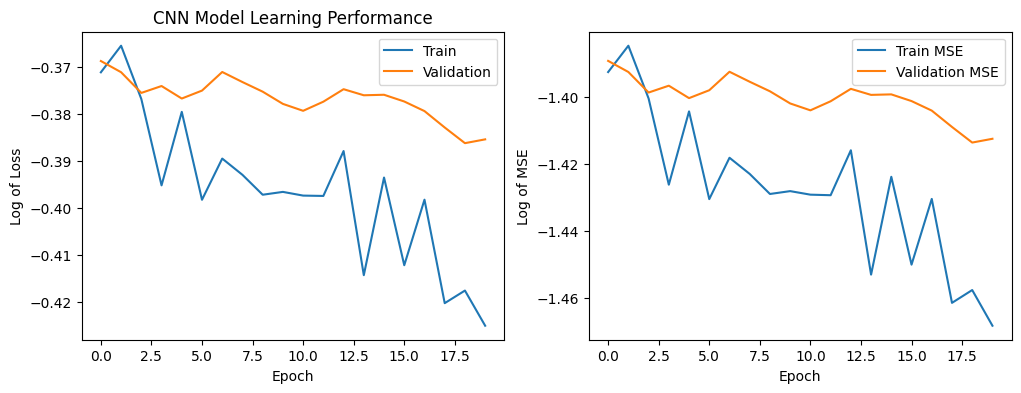

In [ ]:
relu_fun = lambda list_: (abs(list_) + list_) / 2
embedding_dim = 32
filter_sizes = [3, 4, 5]
num_filters = 512
drop = 0.5
epochs = 20
batch_size = 4
use_validation = True
x, y, vocabulary, vocabulary_inv = load_data(avg_len=False, load_saved_data=False, load_testdata=False)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sequence_length = X_train.shape[1]
vocabulary_size = len(vocabulary_inv)

cnn_model, epochs, batch_size = cnn_model(X_train, y_train, vocabulary_size, sequence_length, embedding_dim, filter_sizes, num_filters, drop, epochs, batch_size)
model, history = train_model(cnn_model, X_train, y_train, epochs, batch_size)
plot(history, "CNN", use_validation)

### RNN, LSTM, GRU

In [22]:
def rnn_model(X_train, y_train, vocabulary_size, sequence_length, embedding_dim, num_units, drop, epochs, batch_size):
    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)

    rnn_list = []
    for _ in range(1):
        rnn = SimpleRNN(num_units, return_sequences=True, kernel_initializer='glorot_uniform')(embedding)
        # rnn = Dropout(drop)(rnn)
        rnn_list.append(rnn)

    rnn_output = concatenate(rnn_list, axis=-1)

    flatten = Flatten()(rnn_output)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=2, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=output)
    adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    print(model.summary())

    return model, epochs, batch_size

In [23]:
def lstm_model(X_train, y_train, vocabulary_size, sequence_length, embedding_dim, num_units, drop, epochs, batch_size):
    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)

    lstm_list = []
    for _ in range(1):
      lstm = LSTM(num_units, return_sequences=True, dropout=drop, recurrent_dropout=drop)(embedding)
      # lstm2 = LSTM(num_units, return_sequences=False, dropout=drop, recurrent_dropout=drop)(lstm1)
    lstm_list.append(lstm)

    lstm_output = concatenate(lstm_list, axis=-1)

    flatten = Flatten()(lstm_output)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=2, activation='elu')(dropout)

    model = Model(inputs=inputs, outputs=output)
    adam = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    print(model.summary())

    return model, epochs, batch_size

In [24]:
def gru_model(X_train, y_train, vocabulary_size, sequence_length, embedding_dim, num_units, drop, epochs, batch_size):
    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)

    gru_list = []
    for _ in range(1):
      gru = GRU(num_units, return_sequences=False)(embedding)
    #gru2 = GRU(num_units, return_sequences=True)(gru2)
    gru_list.append(gru)

    gru_output = concatenate(gru_list, axis=-1)

    flatten = Flatten()(gru_output)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=2, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=output)
    adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    print(model.summary())

    return model, epochs, batch_size

### Training for RNN, LSTM, GRU

In [25]:
relu_fun = lambda list_: (abs(list_) + list_) / 2
embedding_dim = 32
filter_sizes = [3, 4, 5]
num_filters = 512
num_units = 128
drop = 0.5
epochs = 10
batch_size = 4
x, y, vocabulary, vocabulary_inv = load_data(avg_len=False, load_saved_data=False, load_testdata=False)
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
# val_size = int(len(X_temp) * 0.25)
# val_X, X_test, val_y, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)
# use_validation=True
sequence_length = X_train.shape[1]
vocabulary_size = len(vocabulary_inv)

model_names = ['LSTM', 'GRU', 'RNN']
models = [lstm_model, gru_model, rnn_model]

accuracy = []
val_loss = []
loss = []
subplot_list = []

Loading and processing token vectors
Maximum vector size: 5241


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5241)]            0         
                                                                 
 embedding_12 (Embedding)    (None, 5241, 32)          2464      
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 5241, 128)         20608     
                                                                 
 concatenate_12 (Concatenat  (None, 5241, 128)         0         
 e)                                                              
                                                                 
 flatten_12 (Flatten)        (None, 670848)            0         
                                                                 
 dropout_23 (Dropout)        (None, 670848)            0         
                                                          

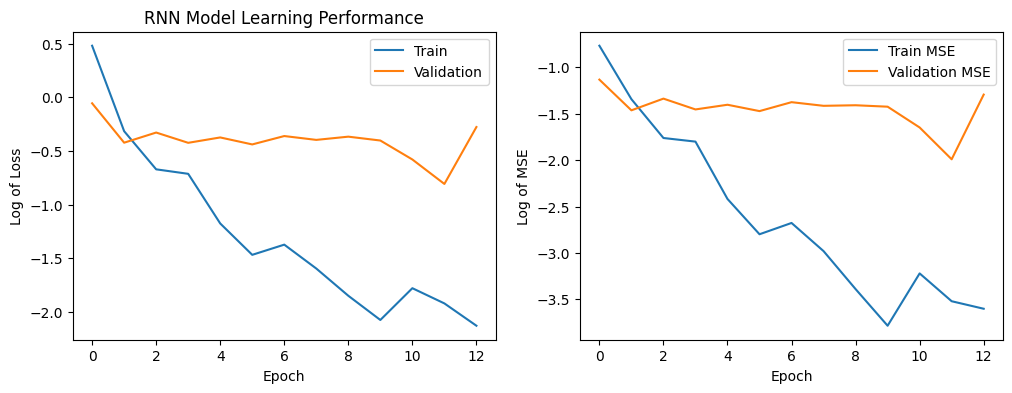

In [ ]:
# Looping through models
epochs = 16
model_names = ['RNN']
models = [rnn_model]
for model_name, model_function in zip(model_names, models):
  model, epochs, batch_size = model_function(X_train, y_train, vocabulary_size, sequence_length, embedding_dim, num_units, drop, epochs, batch_size)

  # Training the model
  use_validation = True
  trained_model, history = train_model(model, X_train, y_train, epochs, batch_size, model_names)

  # Evaluating the model
  # metrics = model.evaluate(X_test, y_test)
  # if len(metrics) >= 2:
  #     accuracy.append(metrics[1])
  # if len(metrics) >= 1:
  #     val_loss.append(metrics[0])
  subplot = plot(history, model_name, use_validation)

# metrics_table = pd.DataFrame({
#     'Model': model_names,
#     'Accuracy': accuracy,
#     'Validation Loss': val_loss,
#     'Loss': loss
# })

# print("\nMetrics Table:")
# print(metrics_table)

subplot

In [ ]:
model_names = ['LSTM', 'GRU']
models = [lstm_model, gru_model]
subplot_list = []

for model_name, model_function in zip(model_names, models):
    model, epochs, batch_size = model_function(X_train, y_train, vocabulary_size, sequence_length, embedding_dim, num_units, drop, epochs, batch_size)

    # Training the model
    use_validation = True
    trained_model, history = train_model(model, X_train, y_train, epochs, batch_size, model_names)
    subplot = plot(history, model_name, use_validation)
    # subplot_list.append(subplot)

# # Create subplots for each model's training history
# fig, axes = plt.subplots(1, len(subplot_list), figsize=(15, 5))

# for i, subplot in enumerate(subplot_list):
#     axes[i].plot(subplot)
    subplot

# plt.tight_layout()
# plt.show()

## Data Preprocessing for Tests (OpenMP and POSIX)

### Modifying exisiting functions for Tests (Speficically input)

In [26]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read()
        result = chardet.detect(rawdata)
    return result['encoding']

def check_folder_encoding(folder_path):
    file_encodings = {}
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            encoding = detect_encoding(file_path)
            if encoding in file_encodings:
                file_encodings[encoding].append(file_path)
            else:
                file_encodings[encoding] = [file_path]
    return file_encodings

with_datarace_path = '/content/drive/MyDrive/Data_Path/Data/Source_Code/POSIX_Lock_Primitives/Test_Set/with_datarace'
without_datarace_path = '/content/drive/MyDrive/Data_Path/Data/Source_Code/POSIX_Lock_Primitives/Test_Set/without_datarace'

print("Encoding types in 'with_datarace' folder:")
with_datarace_encodings = check_folder_encoding(with_datarace_path)
for encoding, files in with_datarace_encodings.items():
    print(f"Encoding: {encoding}, Files: {len(files)}")

print("\nEncoding types in 'without_datarace' folder:")
without_datarace_encodings = check_folder_encoding(without_datarace_path)
for encoding, files in without_datarace_encodings.items():
    print(f"Encoding: {encoding}, Files: {len(files)}")

Encoding types in 'with_datarace' folder:
Encoding: utf-8, Files: 6
Encoding: ascii, Files: 21
Encoding: GB2312, Files: 1
Encoding: MacRoman, Files: 1
Encoding: ISO-8859-1, Files: 1

Encoding types in 'without_datarace' folder:
Encoding: ascii, Files: 23
Encoding: utf-8, Files: 5
Encoding: GB2312, Files: 1
Encoding: MacRoman, Files: 1


In [27]:
def load_data_and_labels_defl(full_path, with_datarace_path, without_datarace_path):
    with_datarace_files = os.listdir(with_datarace_path)
    without_datarace_files = os.listdir(without_datarace_path)
    positive_examples = []
    negative_examples = []
    try_encodings = ['utf-8', 'ascii', 'gb2312', 'macroman', 'iso-8859-1', 'utf-16', 'utf-32']
    if("POSIX_Lock_Primitives" in full_path):
      try:
        successful_read_with_datarace_files=False
        for file in with_datarace_files:
            filename = os.fsdecode(file)
            for encoding in try_encodings:
              try:
                with open(os.path.join(with_datarace_path, filename), 'r', encoding=encoding) as ast_file:
                    token_vector = ast_file.read()
                    positive_examples.append(token_vector)
                    file_names.append(filename)
                    successful_read = True
                    break
              except UnicodeDecodeError:
                  continue
              if successful_read_with_datarace_files == False:
                for file in with_datarace_files:
                  filename = os.fsdecode(file)
                  with open(os.path.join(with_datarace_path, filename), 'r') as ast_file:
                    token_vector = ast_file.read()
                    positive_examples.append(token_vector)
                    file_names.append(filename)

        successful_read_without_datarace_files=False
        for file in without_datarace_files:
            filename = os.fsdecode(file)
            for encoding in try_encodings:
              try:
                with open(os.path.join(without_datarace_path, filename), 'r', encoding=encoding) as ast_file:
                    token_vector = ast_file.read()
                    negative_examples.append(token_vector)
                    file_names.append(filename)
                    successful_read_without_datarace_files = True
                    break
              except UnicodeDecodeError:
                    continue
              if successful_read_without_datarace_files == False:
                for file in with_datarace_files:
                  filename = os.fsdecode(file)
                  with open(os.path.join(with_datarace_path, filename), 'r') as ast_file:
                    token_vector = ast_file.read()
                    positive_examples.append(token_vector)
                    file_names.append(filename)

      except Exception as e:
          print(f"Error: {e}")
          return None
    else:
      for file in with_datarace_files:
            filename = os.fsdecode(file)
            with open(os.path.join(with_datarace_path, filename), 'r') as ast_file:
                token_vector = ast_file.read()
                positive_examples.append(token_vector)
                file_names.append(filename)
      for file in without_datarace_files:
          filename = os.fsdecode(file)
          with open(os.path.join(without_datarace_path, filename), 'r') as ast_file:
              token_vector = ast_file.read()
              negative_examples.append(token_vector)
              file_names.append(filename)

    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = [s.strip() for s in negative_examples]
    x_text = positive_examples + negative_examples
    x_text = [cleaned_string(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)

    return [x_text, y]

In [28]:
def load_test_data_defl(test_x, test_y):
    sentences, labels = test_x, test_y
    sentences_padded = average_length(sentences)
    vocabulary_path = os.path.join(training_data_dest, 'vocabulary.pkl')
    vocabulary_inv_path = os.path.join(training_data_dest, 'vocabulary_inv.pkl')
    with open(vocabulary_path, 'rb') as f:
        vocabulary = pickle.load(f)
        f.close()

    with open(vocabulary_inv_path, 'rb') as f:
        vocabulary_inv = pickle.load(f)
        f.close()
    x, y = build_input_data(sentences_padded, labels, vocabulary)

    return [x, y, vocabulary, vocabulary_inv]

In [29]:
def load_data_defl(train_x, train_y, test_x, test_y, avg_len=False, load_saved_data=False, load_testdata=False):
    if load_testdata:
        return load_test_data_defl(test_x, test_y)
    if load_saved_data:
        print("Loading data from previously saved data")
        return load_prev_saved_data()
    print("Loading and processing token vectors")
    sentences, labels = train_x, train_y
    sentences_padded = average_length(sentences) if avg_len else pad_token_vectors(sentences)
    vocabulary, vocabulary_inv = build_vocabulary_mapping(sentences_padded)
    x, y = build_input_data(sentences_padded, labels, vocabulary)
    save_processed_data(sentences_padded, file_names, vocabulary, vocabulary_inv, x, y)

    return [x, y, vocabulary, vocabulary_inv]

In [30]:
def get_intermediate_outputs(model, sample_data, layer_indices):
    get_layer_output = K.function([model.layers[0].input], [model.layers[i].output for i in layer_indices])
    intermediate_outputs = get_layer_output([np.array([sample_data])])
    return intermediate_outputs

In [31]:
sample = 13

In [32]:
def generate_heatmap(intermediate_outputs, model_weights, predicted_label):
    conv_output_concat = np.concatenate(intermediate_outputs)
    last_layer_weights = model_weights[-2]

    heat_map = np.zeros(sequence_length)
    for i in range(num_filters * len(filter_sizes)):
        heat_map += last_layer_weights[i, predicted_label] * conv_output_concat[i, :]

    return relu_fun(heat_map)

In [34]:
ast_intrst_lines = {}
layer_indices = [2, 3, 4]

In [33]:
def process_heatmap_impact_source_files(heat_map, file_names, sample):
    nums = relu_fun(heat_map).tolist()
    for i in range(len(nums)):
        if nums[i] > 0:
            ast_intrst_lines[i] = nums[i]
            print(str(i) + '\n')

    ast = read_ast(file_names[sample])

    source_lines_probability = extract_source_line_impacts(ast, ast_intrst_lines, method="maximum")
    highlight_source_code(file_names[sample], source_lines_probability, method="MAX")

    source_lines_probability = extract_source_line_impacts(ast, ast_intrst_lines, method="average")
    highlight_source_code(file_names[sample], source_lines_probability, method="AVG")

    source_lines_probability = extract_source_line_impacts(ast, ast_intrst_lines, method="only_parent")
    highlight_source_code(file_names[sample], source_lines_probability, method="PARENT")

In [35]:
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0) * 1000

In [36]:
import zipfile

## Test 1: OpenMP Critical

In [37]:
zip_path = '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Critical.zip'
extract_path = '/content/drive/MyDrive/Data_Path/Data/Source_Code/'

In [41]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [38]:
result_critical_test = load_data_and_labels_defl('/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Critical', '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Critical/Test_Set/with_datarace', '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Critical/Test_Set/without_datarace')

In [39]:
tst_x_critical, tst_y_critical = result_critical_test[0], result_critical_test[1]

In [40]:
result_critical_train  = load_data_and_labels_defl('/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Critical', '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Critical/Train_Set/with_datarace', '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Critical/Train_Set/without_datarace')

In [41]:
tr_x_critical, tr_y_critical = result_critical_train[0], result_critical_train[1]

In [42]:
result_load_critical = load_test_data_defl(tst_x_critical, tst_y_critical)

Average Length is: 219


In [43]:
x_tst_critical, y_tst_critical, vocabulary_tst_critical, vocabulary_inv_tst_critical = result_load_critical[0], result_load_critical[1], result_load_critical[2], result_load_critical[3]

In [44]:
result_data_critical = load_data_defl(tr_x_critical, tr_y_critical, x_tst_critical, y_tst_critical, avg_len=False, load_saved_data=False, load_testdata=False)

Loading and processing token vectors
Maximum vector size: 17143


In [45]:
x_critical, y_critical, vocabulary_critical, vocabulary_inv_critical = result_data_critical[0], result_data_critical[1], result_data_critical[2], result_data_critical[3]

In [46]:
embedding_dim = 32
filter_sizes = [3, 4, 5]
num_filters = 512
drop = 0.5
epochs = 16
batch_size = 4
use_validation = True

### Training the CNN - Critical

In [ ]:
x_c, y_c, vocabulary_c, vocabulary_inv_c = x_critical, y_critical, vocabulary_critical, vocabulary_inv_critical
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x_c, y_c, test_size=0.2, random_state=42)
sequence_length_c = X_train_c.shape[1]
vocabulary_size_c = len(vocabulary_inv_c)

cnn_model_c, epochs, batch_size = cnn_model(X_train_c, y_train_c, vocabulary_size_c, sequence_length_c, embedding_dim, filter_sizes, num_filters, drop, epochs, batch_size)
model_c, history_c = train_model(cnn_model_c, X_train_c, y_train_c, epochs, batch_size)
plot(history_c, "CNN", use_validation)

### Evaluation

In [ ]:
score_c = model_c.evaluate(X_test_c, y_test_c, verbose=1)
print(score_c)

for i, x in enumerate(file_names):
    print(x)
    print(model_c.predict(X_test_c[i:i+1]))

y_pred_c = model_c.predict(X_test_c[28:30])
print(y_pred_c)

In [ ]:
y_pred_c = model_c.predict(np.array([X_test_c[sample]]))
print('classifier prediction: {}'.format(y_pred_c))

predicted_label_c = 0 if (y_pred_c[0][0] > y_pred_c[0][1]) else 1
print('predected label: {}'.format(predicted_label_c))

In [ ]:
intermediate_outputs_c = get_intermediate_outputs(model_c, sample, layer_indices)

In [ ]:
last_layer_w_c = model_c.get_weights()[-2]
heat_map_c = generate_heatmap(intermediate_outputs_c, last_layer_w_c, predicted_label_c)

print(heat_map_c.tolist()[:500])

print(softmax(heat_map_c).tolist()[:500])

In [ ]:
process_heatmap_impact_source_files(heat_map_c, file_names, sample)

## Test 2: OpenMP Private

In [47]:
zip_path_private = '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Private.zip'
extract_path_private = '/content/drive/MyDrive/Data_Path/Data/Source_Code/'

In [54]:
with zipfile.ZipFile(zip_path_private, 'r') as zip_ref:
    zip_ref.extractall(extract_path_private)

KeyboardInterrupt: ignored

In [48]:
result_private_test = load_data_and_labels_defl('/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Private', '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Private/Test_Set/with_datarace', '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Private/Test_Set/without_datarace')

In [49]:
tst_x_private, tst_y_private = result_private_test[0], result_private_test[1]

In [51]:
result_private_train = load_data_and_labels_defl('/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Private', '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Private/Train_Set/with_datarace', '/content/drive/MyDrive/Data_Path/Data/Source_Code/OMP_Private/Train_Set/without_datarace')

In [52]:
tr_x_private, tr_y_private = result_private_train[0], result_private_train[1]

In [53]:
result_load_private = load_test_data_defl(tst_x_private, tst_y_private)

Average Length is: 557


In [54]:
x_tst_private, y_tst_private, vocabulary_tst_private, vocabulary_inv_tst_private = result_load_private[0], result_load_private[1], result_load_private[2], result_load_private[3]

In [55]:
result_data_private = load_data_defl(tst_x_private, tr_y_private, x_tst_private, y_tst_private, avg_len=False, load_saved_data=False, load_testdata=False)

Loading and processing token vectors
Maximum vector size: 16909


In [56]:
x_private, y_private, vocabulary_private, vocabulary_inv_private = result_data_private[0], result_data_private[1], result_data_private[2], result_data_private[3]

### Training the CNN - Private

In [ ]:
x_p, y_p, vocabulary_p, vocabulary_inv_p = load_data(avg_len=False, load_saved_data=False, load_testdata=False)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(x_p, y_p, test_size=0.2, random_state=42)
sequence_length = X_train_p.shape[1]
vocabulary_size_p = len(vocabulary_inv_p)

cnn_model_p, epochs_p, batch_size_p = cnn_model(X_train_p, y_train_p, vocabulary_size_p, sequence_length, embedding_dim, filter_sizes, num_filters, drop, epochs, batch_size)
model_p, history_p = train_model(cnn_model_p, X_train_p, y_train_p, epochs, batch_size)
plot(history_p, "CNN", use_validation)

### Evaluation - Private

In [ ]:
score_p = model_p.evaluate(X_test_p, y_test_p, verbose=1)
print(score_p)

for i, x in enumerate(file_names):
    print(x)
    print(model_p.predict(X_test_p[i:i+1]))

y_pred_p = model_p.predict(X_test_p[28:30])
print(y_pred_p)

In [ ]:
y_pred_p = model_p.predict(np.array([X_test_p[sample]]))
print('classifier prediction: {}'.format(y_pred_p))

predicted_label_p = 0 if (y_pred_p[0][0] > y_pred_p[0][1]) else 1
print('predected label: {}'.format(predicted_label_p))

In [ ]:
intermediate_outputs_p = get_intermediate_outputs(model_p, sample, layer_indices)

In [ ]:
last_layer_w_p = model_p.get_weights()[-2]
heat_map_p = generate_heatmap(intermediate_outputs_p, last_layer_w_p, predicted_label_p)

print(heat_map_p.tolist()[:500])

print(softmax(heat_map_p).tolist()[:500])

In [ ]:
process_heatmap_impact_source_files(heat_map_p, file_names, sample)

## Test 3: POSIX Lock Primitives

In [61]:
zip_path_private = '/content/drive/MyDrive/Data_Path/Data/Source_Code/POSIX_Lock_Primitives.zip'
extract_path_private = '/content/drive/MyDrive/Data_Path/Data/Source_Code/'

In [ ]:
with zipfile.ZipFile(zip_path_private, 'r') as zip_ref:
    zip_ref.extractall(extract_path_private)

In [62]:
result_primitive_locks_test = load_data_and_labels_defl('/content/drive/MyDrive/Data_Path/Data/Source_Code/POSIX_Lock_Primitives', '/content/drive/MyDrive/Data_Path/Data/Source_Code/POSIX_Lock_Primitives/Test_Set/with_datarace', '/content/drive/MyDrive/Data_Path/Data/Source_Code/POSIX_Lock_Primitives/Test_Set/without_datarace')

In [63]:
tst_x_primitive_locks, tst_y_primitive_locks = result_primitive_locks_test[0], result_primitive_locks_test[1]

In [ ]:
result_primitive_locks_train = load_data_and_labels_defl('/content/drive/MyDrive/Data_Path/Data/Source_Code/POSIX_Lock_Primitives', '/content/drive/MyDrive/Data_Path/Data/Source_Code/POSIX_Lock_Primitives/Train_Set/with_datarace', '/content/drive/MyDrive/Data_Path/Data/Source_Code/POSIX_Lock_Primitives/Train_Set/without_datarace')

In [ ]:
tr_x_primitive_locks, tr_y_primitive_locks = result_primitive_locks_train[0], result_primitive_locks_train[1]

In [ ]:
result_load_primitive_locks = load_test_data_defl(tst_x_primitive_locks, tst_y_primitive_locks)

In [ ]:
x_tst_primitive_locks, y_tst_primitive_locks, vocabulary_tst_primitive_locks, vocabulary_inv_tst_primitive_locks = result_load_primitive_locks[0], result_load_primitive_locks[1], result_load_primitive_locks[2], result_load_primitive_locks[3]

In [ ]:
result_data_primitive_locks = load_data_defl(tst_x_primitive_locks, tr_y_primitive_locks, x_tst_primitive_locks, y_tst_primitive_locks, avg_len=False, load_saved_data=False, load_testdata=False)

In [ ]:
x_primitive_locks, y_primitive_locks, vocabulary_primitive_locks, vocabulary_inv_primitive_locks = result_data_primitive_locks[0], result_data_primitive_locks[1], result_data_primitive_locks[2], result_data_primitive_locks[3]

### Training the CNN - Primitive Locks

In [ ]:
x_primitive_locks, y_primitive_locks, vocabulary_primitive_locks, vocabulary_inv_primitive_locks = load_data(avg_len=False, load_saved_data=False, load_testdata=False)
X_train_primitive_locks, X_test_primitive_locks, y_train_primitive_locks, y_test_primitive_locks = train_test_split(x_primitive_locks, y_primitive_locks, test_size=0.2, random_state=42)
sequence_length = X_train_primitive_locks.shape[1]
vocabulary_size_primitive_locks = len(vocabulary_inv_primitive_locks)

cnn_model_primitive_locks, epochs_primitive_locks, batch_size_primitive_locks = cnn_model(X_train_primitive_locks, y_train_primitive_locks, vocabulary_size_primitive_locks, sequence_length, embedding_dim, filter_sizes, num_filters, drop, epochs, batch_size)
model_primitive_locks, history_primitive_locks = train_model(cnn_model_primitive_locks, X_train_primitive_locks, y_train_primitive_locks, epochs, batch_size)
plot(history_primitive_locks, "CNN", use_validation)

### Evaluation - Primitive Locks

In [ ]:
score_primitive_locks = model_primitive_locks.evaluate(X_test_primitive_locks, y_test_primitive_locks , verbose=1)
print(score_primitive_locks)

for i, x in enumerate(file_names):
    print(x)
    print(model_primitive_locks.predict(X_test_primitive_locks[i:i+1]))

y_pred_primitive_locks = model_primitive_locks.predict(X_test_primitive_locks[28:30])
print(y_pred_primitive_locks )

In [ ]:
y_pred_primitive_locks = model_p.predict(np.array([X_test_primitive_locks[sample]]))
print('classifier prediction: {}'.format(y_pred_primitive_locks))

predicted_label_primitive_locks = 0 if (y_pred_primitive_locks[0][0] > y_pred_primitive_locks[0][1]) else 1
print('predected label: {}'.format(predicted_label_primitive_locks))

In [ ]:
intermediate_outputs_primitive_locks = get_intermediate_outputs(model_primitive_locks, sample, layer_indices)

In [ ]:
last_layer_w_primitive_locks = model_primitive_locks.get_weights()[-2]
heat_map_primtive_locks = generate_heatmap(intermediate_outputs_primitive_locks, last_layer_w_primitive_locks, predicted_label_primitive_locks)

print(heat_map_primtive_locks.tolist()[:500])

print(softmax(heat_map_primtive_locks).tolist()[:500])

In [ ]:
# Evaluating the model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print(score)

# Making predictions
for i, x in enumerate(file_names[:10]):
    print(x)
    print(model.predict(X_test[i:i+1]))

y_pred = model.predict(X_test[10:13])
print(y_pred)

1/1 [==============================] - 1s 676ms/step - loss: 0.6772 - accuracy: 0.6923 - mse: 0.2420
[0.67718505859375, 0.692307710647583, 0.24202412366867065]
lec4_-_main.c.txt
1/1 [==============================] - 0s 149ms/step
[[0.5097483 0.4902517]]
11_-_main.c.txt
1/1 [==============================] - 0s 60ms/step
[[0.48538163 0.51461834]]
nbodymp_-_main.c.txt
1/1 [==============================] - 0s 58ms/step
[[0.5283178 0.4716822]]
omp_criatm_-_main.c.txt
1/1 [==============================] - 0s 59ms/step
[[0.50518    0.49482003]]
1.2-hello-single_-_main.c.txt
1/1 [==============================] - 0s 61ms/step
[[0.51028055 0.48971942]]
calcpi_omp_-_main.c.txt
1/1 [==============================] - 0s 72ms/step
[[0.5196847  0.48031524]]
mandelbrotpar_-_main.c.txt
1/1 [==============================] - 0s 67ms/step
[[0.49553883 0.50446117]]
mmOMP_-_main.c.txt
1/1 [==============================] - 0s 90ms/step
[[0.511697 0.488303]]
ej2openmpsections_-_main.c.txt
1/1 [========

In [ ]:
get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[2].output,
                                                            model.layers[3].output,
                                                            model.layers[4].output])

In [ ]:
predictions = []

for sample in range(13):
    y_pred = model.predict(np.array([X_test[sample]]))
    # Determining the predicted label based on the probability values
    predicted_label = 0 if (y_pred[0][0] > y_pred[0][1]) else 1
    predictions.append(predicted_label)

print('Predictions for test samples 0 to 13:', predictions)

1/1 [==============================] - 0s 66ms/step
Predictions for test samples 0 to 13: [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1]


In [ ]:
# getting the intermediate output
conv_output1 = (get_3rd_layer_output([np.array([X_test[sample]])])[0][0]).T
conv_output2 = (get_3rd_layer_output([np.array([X_test[sample]])])[1][0]).T
conv_output3 = (get_3rd_layer_output([np.array([X_test[sample]])])[2][0]).T
conv_output_concat = np.concatenate((conv_output1, conv_output2, conv_output3))

In [ ]:
# getting the weights of the last layer
last_layer_w = model.get_weights()[-2]

In [ ]:
# Generating the heat map using vectorized operations
heat_map = np.sum(last_layer_w[:, predicted_label][:, np.newaxis] * conv_output_concat, axis=0)

# Displaying the heat map after applying ReLU activation function
print(relu_fun(heat_map).tolist()[:500])

[0.0, 0.008259064592662568, 0.011094805876155078, 0.0006591187854763092, 0.0, 0.0, 0.02199721668776533, 0.0007214851736883077, 0.007644688370007202, 0.0, 0.00799424483769684, 0.0, 0.012456298366690266, 0.0024453073255585878, 0.0, 0.024267108310056074, 0.017349411837813022, 0.023250948226461787, 0.0, 0.010818155102498395, 0.0220922159168353, 0.0, 0.008214450664183914, 0.021992684940315144, 0.013022859460875225, 0.0, 0.011893509808317049, 0.019321672091589193, 0.028550511833557835, 0.0, 0.013591750858147122, 0.016775202492116392, 0.010923093344437973, 0.018622070879700914, 0.0005587860004823142, 0.0054710383377312155, 0.02897020145998397, 0.0, 0.04971817500639464, 0.0011969822780457662, 0.029368431061755018, 0.0, 0.007376781408495958, 0.0, 0.009818404996650543, 0.01390063237945327, 0.0, 0.0007258064638051565, 0.0016625237710741203, 0.014755651877337073, 0.0, 0.0013345247262890325, 0.003738731822593877, 0.012212880014786265, 0.011548811871463727, 0.014192830205068674, 0.01897021212047889,

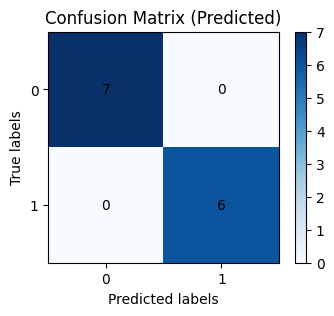

In [ ]:
predicted_labels = [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1]

conf_matrix = np.zeros((2, 2))

for pred in predicted_labels:
    conf_matrix[pred, pred] += 1

plt.figure(figsize=(4, 3))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(int(conf_matrix[i, j])), ha='center', va='center', color='black')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Predicted)')
plt.colorbar()
plt.xticks(np.arange(2))
plt.yticks(np.arange(2))
plt.show()

In [ ]:
# keeping track of the line of token in AST and also its impact probability
ast_intrst_lines = {}

nums = relu_fun(heat_map).tolist()
for i in range(len(nums)):
    if nums[i] > 0:
        ast_intrst_lines[i] = nums[i]
        print(str(i) + '\n')

4

10

11

12

16

18

19

22

23

29

31

32

39

40

48

51

54

57

60

63

66

69

72

75

78

81

86

88

89

90

91

95

96

102

103

109

110

116

117

123

129

135

138

140

141

142

143

144

164

166

167

170

172

173

176

180

182

183

186

187

202

204

210

211

214

215

221

223

224

225

226

228

230

233

235

236

239

241

242

243

244

245

301

304

329

330

333

339

341

342

346

352

356

359

364

367

368

375

376

379

381

383

385

390

392

394

396

401

403

405

407

409

411

412

415

417

420

422

424

426

428

429

432

434

437

439

441

444

447

449

451

452

457

460

461

469

470

472

473

476

479

481

483

485

490

492

494

496

501

503

505

507

509

511

512

515

517

520

522

524

526

528

529

532

534

537

539

541

544

547

549

551

553

555

557

559

560

562

565

566

568

571

573

574

576

579

580

582

585

587

588

590

593

594

596

598

601

603

605

609

611

613

614

616

619

620

623


In [ ]:
# reading the untouched AST
ast = read_ast(file_names[sample])

# Creating dictionaries of source code line and its impact values using different methods
source_lines_probability = extract_source_line_impacts(ast, ast_intrst_lines, method="maximum")
highlight_source_code(file_names[sample], source_lines_probability, method="MAX")

source_lines_probability = extract_source_line_impacts(ast, ast_intrst_lines, method="average")
highlight_source_code(file_names[sample], source_lines_probability, method="AVG")

source_lines_probability = extract_source_line_impacts(ast, ast_intrst_lines, method="only_parent")
highlight_source_code(file_names[sample], source_lines_probability, method="PARENT")


Streaming output truncated to the last 5000 lines.
going to line 91 in AST
going to line 90 in AST
going to line 89 in AST
going to line 88 in AST
going to line 87 in AST
going to line 86 in AST
going to line 85 in AST
going to line 84 in AST
going to line 83 in AST
going to line 82 in AST
going to line 81 in AST
going to line 80 in AST
going to line 79 in AST
going to line 78 in AST
going to line 77 in AST
going to line 76 in AST
going to line 75 in AST
going to line 74 in AST
going to line 73 in AST
found the source code line number
source code line is 10
181
found the source code line number
source code line is 7
182
line number not found
going to line 181 in AST
found the source code line number
source code line is 7
184
found the source code line number
source code line is 9
186
found the source code line number
source code line is 10
189
line number not found
going to line 188 in AST
found the source code line number
source code line is 12
190
found the source code line number
so

In [ ]:
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0) * 1000
print(softmax(relu_fun(heat_map)).tolist()[:500])

[0.1901394151209273, 0.19171629163099685, 0.19226072099947855, 0.1902647808922218, 0.1901394151209273, 0.1901394151209273, 0.19436829430180796, 0.19027664738944142, 0.191598541874952, 0.1901394151209273, 0.1916655280915149, 0.1901394151209273, 0.19252266080141858, 0.19060493336121662, 0.1901394151209273, 0.1948099903761421, 0.19346700453283278, 0.19461213278455522, 0.1901394151209273, 0.19220753927899148, 0.19438676001702274, 0.1901394151209273, 0.19170773860486728, 0.1943674134757817, 0.19263176755568012, 0.1901394151209273, 0.19241434173391686, 0.1938489483387764, 0.19564622987235675, 0.1901394151209273, 0.19274138528842003, 0.1933559458592617, 0.192227710258586, 0.19371337880742898, 0.19024569205450279, 0.1911825259984809, 0.19572835779839734, 0.1901394151209273, 0.1998317458813716, 0.19036714489824857, 0.19580631814640762, 0.1901394151209273, 0.19154721816706463, 0.1901394151209273, 0.19201547579499412, 0.19280092873618854, 0.1901394151209273, 0.19027746963181383, 0.190455789335338